In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import fastai
#from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
#from fastai.tabular import *
import scipy.signal as s
#import pyts
from itertools import chain 
from fastai.callbacks import *
import sklearn.metrics as smetrics

In [98]:
#Sets the random seed for everything being used with fastai.
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
path = Path("data/LFP_Prediction")

In [5]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")
df = df.iloc[:len(labels)]

In [7]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [99]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        return int(self.data_input[self.items[i], -1] == 1)

In [100]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            nn.Linear(1280, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [101]:
def isNan(num):
    return num != num

#Returns accuracy where the truth value is 1 (peak is above).
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

#Returns accuracy where the truth value is 0 (peak is bellow).
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

kappa = KappaScore()
auc_roc = AUROC()

In [102]:
#Makes the train and test data sets out of the five folds.
def make_cross_data(splits, test_num, num_back, data_input, seed):
    valid_num = (test_num + 1) % 5
    
    #Concatenates together all of the splits that are not the test set.
    #The validation split is put first.
    inds = splits[valid_num]
    for i in range(5):
        if i != valid_num and i != test_num:
            inds = np.concatenate((inds, splits[i]))
            
    random_seed(seed, True)
    train_data = (TimeWindowList(inds, num_back, data_input)
                .split_by_idx(range(len(splits[0])))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    #Creates the data out of the test split for evaluation.
    random_seed(seed, True)
    test_data = (TimeWindowList(splits[test_num], num_back, data_input)
                .split_none()
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    return train_data, test_data

In [103]:
#Performs given metrics on given model with the given data.
#Also performs kappa and auc_roc, as well as returns the confusion matrix.
def get_scores(learn, data, metrics):
    learn.data = data
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    preds = np.array(interp.preds)
    kappa = smetrics.cohen_kappa_score(interp.y_true, preds.argmax(1))
    auc = smetrics.roc_auc_score(interp.y_true, preds[:, 1])
    return [interp.confusion_matrix()] + [metric(interp.preds, interp.y_true) for metric in metrics] + [kappa, auc]

In [104]:
#Performs 5 fold cross validation.
#Returns the evaluations for each fold.
def do_cross_valid(num_vars, indexes, data_input, num_back, train_metrics, test_metrics, wd, lr, epochs, base_name = None, num_start = 1, loss_func = None):
    res = []#Stores the evaluation scores for each fold.
    
    #Makes indexes divisible by 5 so it can be split evenly.
    indexes = np.array(indexes)[:-(len(indexes) % 5)]
    #Gets the five folds.
    splits = np.split(np.array(indexes), 5)
    
    for i in range(5):
        num_label = num_start + i
        train_data, test_data = make_cross_data(splits, i, num_back, data_input, num_label)
        
        #Creates the model.
        random_seed(num_label, True)
        if loss_func != None:
            learn = Learner(train_data, CNNModel(2, num_vars), loss_func = loss_func, metrics = train_metrics, wd = wd)
        else:
            learn = Learner(train_data, CNNModel(2, num_vars), metrics = train_metrics, wd = wd)
        
        #Decides where the model will be saved or if it should be saved.
        random_seed(num_label, True)
        if base_name != None:
            name = base_name + str(num_label)
        else:
            name = "model"
            
        #Used  for early stopping and saving the epoch with the best validation loss.
        callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=name)]
        
        #Fits the model.
        random_seed(num_label, True)
        learn.fit_one_cycle(epochs, lr, callbacks= callbacks)
        
        #Evaluates the model.
        res.append(get_scores(learn, test_data, test_metrics))
        
    return res

In [ ]:
def num_to_percent(arr):
    arr = arr

In [105]:
num_back = 40

# Class Imbalance

In [28]:
columns = df.columns
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [106]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)]  + [labels.next_above], axis = -1)

In [107]:
#Percent of input that is labeled as above threshold.
(len(np.where(np.array(labels.next_above) == 1)[0]) / len(df)) * 100

13.696939287506272

In [108]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = [i for i in range(100, len(df) - 30000) if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1]

In [109]:
len(indexes)

33552

In [110]:
#Metrics calculated each epoch during training.
train_metrics = [accuracy, true_acc, false_acc, kappa]

In [111]:
#Metrics used for evaluation of each fold.
test_metrics = [accuracy, true_acc, false_acc]

## Unaltered Control

In [73]:
num_vars = 19

In [80]:
random_seed(42, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [82]:
learn = Learner(train_data, CNNModel(2, num_vars), wd = 1e-4)

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


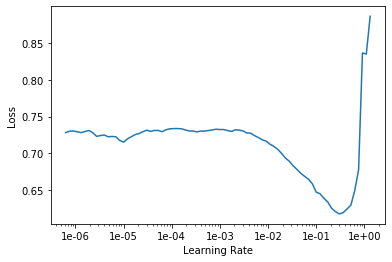

In [84]:
#Helps to choose a learning rate.
#Choose where there is steep decline and then a little back from that.
learn.recorder.plot()

In [96]:
results = do_cross_valid(19, indexes, data_input, num_back, train_metrics, test_metrics, 1e-4, 1e-2, 25)

33550


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.466925,0.416340,0.857824,0.000000,1.000000,0.000000,00:18
1,0.389623,0.364822,0.857824,0.000000,1.000000,0.000000,00:18
2,0.333495,0.392454,0.860507,0.009760,1.000000,0.031940,00:18
3,0.335064,0.359617,0.860507,0.010290,1.000000,0.031940,00:18
4,0.331693,0.521731,0.762444,0.618728,0.773784,0.317822,00:18
5,0.333291,0.329447,0.860954,0.012187,1.000000,0.037180,00:18
6,0.325972,0.301058,0.878540,0.192147,0.987472,0.291799,00:18
7,0.309916,0.302410,0.873472,0.141443,0.990666,0.229680,00:18
8,0.314447,0.299160,0.872727,0.134187,0.989859,0.226650,00:18
9,0.301806,0.303852,0.869598,0.082821,0.997989,0.147407,00:18


Better model found at epoch 0 with valid_loss value: 0.41633981466293335.
Better model found at epoch 1 with valid_loss value: 0.3648223876953125.
Better model found at epoch 3 with valid_loss value: 0.3596172630786896.
Better model found at epoch 5 with valid_loss value: 0.3294469714164734.
Better model found at epoch 6 with valid_loss value: 0.3010578751564026.
Better model found at epoch 8 with valid_loss value: 0.29915952682495117.
Better model found at epoch 14 with valid_loss value: 0.2984178364276886.
Better model found at epoch 17 with valid_loss value: 0.29802149534225464.
Better model found at epoch 20 with valid_loss value: 0.2940550446510315.


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.472178,0.398370,0.872578,0.000000,1.000000,0.000000,00:18
1,0.396911,0.374539,0.872578,0.000000,1.000000,0.000000,00:18
2,0.329301,0.288902,0.878987,0.050742,0.996237,0.114357,00:18
3,0.335054,0.298139,0.875261,0.023330,0.997558,0.057206,00:18
4,0.319085,0.311877,0.875410,0.022149,0.998196,0.054364,00:18
5,0.320363,0.291075,0.874665,0.014303,0.998974,0.036527,00:18
6,0.320223,0.286660,0.877347,0.036406,0.997893,0.080692,00:18
7,0.306299,0.289561,0.884501,0.127979,0.989732,0.224659,00:18
8,0.313832,0.271381,0.888227,0.222940,0.978356,0.327390,00:18
9,0.306119,0.279956,0.881073,0.070500,0.995831,0.143548,00:18


Better model found at epoch 0 with valid_loss value: 0.3983704447746277.
Better model found at epoch 1 with valid_loss value: 0.37453922629356384.
Better model found at epoch 2 with valid_loss value: 0.28890153765678406.
Better model found at epoch 6 with valid_loss value: 0.28665968775749207.
Better model found at epoch 8 with valid_loss value: 0.2713812291622162.
Epoch 14: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.446495,0.385662,0.860954,0.000000,1.000000,0.000000,00:18
1,0.372611,0.324661,0.869300,0.056371,0.998422,0.110927,00:18
2,0.332676,0.302033,0.880179,0.191191,0.985734,0.294853,00:18
3,0.321172,0.353416,0.863934,0.017130,1.000000,0.036349,00:18
4,0.316625,0.306274,0.877347,0.102488,0.998486,0.196258,00:18
5,0.321275,0.307081,0.877347,0.102449,0.999078,0.192844,00:18
6,0.328359,0.306814,0.876602,0.101752,0.998346,0.189661,00:18
7,0.311442,0.327516,0.864083,0.013576,1.000000,0.038137,00:18
8,0.309315,0.295223,0.876304,0.100203,0.997992,0.188850,00:18
9,0.314092,0.322267,0.885246,0.276833,0.976528,0.378213,00:18


Better model found at epoch 0 with valid_loss value: 0.3856618106365204.
Better model found at epoch 1 with valid_loss value: 0.32466062903404236.
Better model found at epoch 2 with valid_loss value: 0.3020326793193817.
Better model found at epoch 8 with valid_loss value: 0.29522284865379333.
Better model found at epoch 12 with valid_loss value: 0.29227885603904724.
Epoch 18: early stopping


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.505481,0.416609,0.861848,0.000000,1.000000,0.000000,00:18
1,0.386787,0.374364,0.861848,0.000000,1.000000,0.000000,00:18
2,0.347382,0.311470,0.869300,0.050485,0.998093,0.102959,00:18
3,0.331164,0.324824,0.863040,0.008623,0.999431,0.019348,00:18
4,0.320656,0.329938,0.864978,0.018501,0.999383,0.042829,00:18
5,0.323955,0.306042,0.863189,0.007130,1.000000,0.016618,00:18
6,0.311175,0.284847,0.883905,0.182180,0.990131,0.299628,00:18
7,0.314158,0.291225,0.874069,0.086553,0.995770,0.170092,00:18
8,0.311090,0.297707,0.872876,0.072134,0.997969,0.143982,00:18
9,0.308257,0.292288,0.890462,0.309662,0.972228,0.429723,00:18


Better model found at epoch 0 with valid_loss value: 0.416608989238739.
Better model found at epoch 1 with valid_loss value: 0.374363511800766.
Better model found at epoch 2 with valid_loss value: 0.31146958470344543.
Better model found at epoch 5 with valid_loss value: 0.3060416281223297.
Better model found at epoch 6 with valid_loss value: 0.2848474383354187.
Better model found at epoch 10 with valid_loss value: 0.2802067697048187.
Better model found at epoch 11 with valid_loss value: 0.2800508141517639.
Better model found at epoch 16 with valid_loss value: 0.27975594997406006.
Better model found at epoch 19 with valid_loss value: 0.27897289395332336.
Better model found at epoch 21 with valid_loss value: 0.2785484790802002.
Better model found at epoch 23 with valid_loss value: 0.27830126881599426.


epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,kappa_score,time
0,0.467097,0.398577,0.874367,0.000000,1.000000,0.000000,00:18
1,0.421078,0.379531,0.874367,0.000000,1.000000,0.000000,00:19
2,0.349655,0.293620,0.888674,0.157135,0.989256,0.258724,00:18
3,0.319143,0.286807,0.885693,0.119958,0.993182,0.199628,00:18
4,0.327675,0.286534,0.885544,0.131016,0.989055,0.224634,00:18
5,0.309443,0.300490,0.887928,0.220565,0.976683,0.322704,00:18
6,0.315354,0.281194,0.891356,0.216001,0.981393,0.328476,00:18
7,0.312667,0.306987,0.876453,0.014042,0.999778,0.030386,00:18
8,0.311865,0.286958,0.882414,0.069697,0.997116,0.130474,00:19
9,0.320532,0.286629,0.885544,0.091073,0.997076,0.168034,00:19


Better model found at epoch 0 with valid_loss value: 0.39857685565948486.
Better model found at epoch 1 with valid_loss value: 0.37953129410743713.
Better model found at epoch 2 with valid_loss value: 0.293620228767395.
Better model found at epoch 3 with valid_loss value: 0.28680720925331116.
Better model found at epoch 4 with valid_loss value: 0.28653445839881897.
Better model found at epoch 6 with valid_loss value: 0.2811938226222992.
Better model found at epoch 10 with valid_loss value: 0.27214521169662476.
Better model found at epoch 15 with valid_loss value: 0.27210307121276855.
Epoch 21: early stopping


In [113]:
arr = results[0][0]

In [116]:
arr[0] / arr[0].sum()

array([0.986763, 0.013237])

In [117]:
arr[1] / arr[1].sum()

array([0.750894, 0.249106])

In [97]:
results

[[array([[5740,   77],
         [ 630,  209]], dtype=int64),
  tensor(0.8938),
  tensor(0.2491),
  tensor(0.9868),
  0.32852023061341085,
  0.8646546444466437],
 [array([[5605,  102],
         [ 690,  259]], dtype=int64),
  tensor(0.8810),
  tensor(0.2729),
  tensor(0.9821),
  0.343859524217898,
  0.8561207161892213],
 [array([[5766,   46],
         [ 737,  107]], dtype=int64),
  tensor(0.8824),
  tensor(0.1268),
  tensor(0.9921),
  0.18284139529691268,
  0.861166878137405],
 [array([[5713,   21],
         [ 739,  183]], dtype=int64),
  tensor(0.8858),
  tensor(0.1985),
  tensor(0.9963),
  0.28937638372236774,
  0.8647510719255013],
 [array([[5663,   73],
         [ 697,  223]], dtype=int64),
  tensor(0.8843),
  tensor(0.2424),
  tensor(0.9873),
  0.32109127286908457,
  0.8777336880722819]]